<a href="https://colab.research.google.com/github/likhitha2223/ML-projects/blob/main/mini_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the dataset
!wget https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz?download=1
!tar -zxvf CUB_200_2011.tgz?download=1

Streaming output truncated to the last 5000 lines.
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0050_111087.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0079_113288.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0004_111989.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0068_113247.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0127_111935.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0094_112773.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0028_113217.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0126_110959.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0007_111029.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0096_111519.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0120_113001.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0010_112678.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0025_111669.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0084_111300.j

In [ ]:
# Importing libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random

In [ ]:
print(os.listdir('/content/CUB_200_2011'))

['classes.txt', 'README', 'image_class_labels.txt', 'train_test_split.txt', 'images', 'images.txt', 'parts', 'attributes', 'bounding_boxes.txt']


In [ ]:
# Reading the dataset
from os import walk

for (path, directory, files) in walk('/content/CUB_200_2011'):
    print("Directory path: ", path)
    print("Folder name: ", directory)
#   print("File name: ", filenames)

Directory path:  /content/CUB_200_2011
Folder name:  ['images', 'parts', 'attributes']
Directory path:  /content/CUB_200_2011/images
Folder name:  ['001.Black_footed_Albatross', '069.Rufous_Hummingbird', '173.Orange_crowned_Warbler', '147.Least_Tern', '197.Marsh_Wren', '032.Mangrove_Cuckoo', '130.Tree_Sparrow', '034.Gray_crowned_Rosy_Finch', '027.Shiny_Cowbird', '047.American_Goldfinch', '123.Henslow_Sparrow', '090.Red_breasted_Merganser', '177.Prothonotary_Warbler', '110.Geococcyx', '199.Winter_Wren', '054.Blue_Grosbeak', '142.Black_Tern', '193.Bewick_Wren', '093.Clark_Nutcracker', '043.Yellow_bellied_Flycatcher', '139.Scarlet_Tanager', '086.Pacific_Loon', '145.Elegant_Tern', '140.Summer_Tanager', '068.Ruby_throated_Hummingbird', '002.Laysan_Albatross', '191.Red_headed_Woodpecker', '053.Western_Grebe', '055.Evening_Grosbeak', '126.Nelson_Sharp_tailed_Sparrow', '020.Yellow_breasted_Chat', '014.Indigo_Bunting', '198.Rock_Wren', '024.Red_faced_Cormorant', '101.White_Pelican', '103.Sayorn

In [ ]:
# Define transformations on training and testing data
transform_train = v2.Compose([
    v2.Resize((224,224)),
    v2.RandomCrop(224, padding=4),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # mean and std for 3 channels specofic to ImageNet dataset
])

transform_test = v2.Compose([
    v2.Resize((224,224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
# Create custom dataset
class BirdData(Dataset):
    def __init__(self, root_dir, train, transform=None):
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        self._load_data()
        self.images_dir = '/content/CUB_200_2011/images'


    def _load_data(self):
        images_path = os.path.join(self.root_dir, 'CUB_200_2011', 'images.txt')
        labels_path = os.path.join(self.root_dir, 'CUB_200_2011', 'image_class_labels.txt')
        split_path = os.path.join(self.root_dir, 'CUB_200_2011', 'train_test_split.txt')

        print("Images path:", images_path)
        print("Labels path:", labels_path)
        print("Split path:", split_path)

        # Check if files exist
        for file_path in [images_path, labels_path, split_path]:
            if not os.path.exists(file_path):
                raise FileNotFoundError(f"File not found: {file_path}")

        images = pd.read_csv(images_path, sep=' ', names=['ID', 'path'], index_col='ID')
        labels = pd.read_csv(labels_path, sep=' ', names=['ID', 'label'], index_col='ID')
        split = pd.read_csv(split_path, sep=' ', names=['ID', 'train'], index_col='ID')

        # Merge dataframes
        data = pd.concat([images, labels, split], axis=1)

        # Filtering based on train/test split
        if self.train:
            self.data = data.loc[data['train'] == 1]
        else:
            self.data = data.loc[data['train'] == 0]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        path, label = self.data.iloc[index]['path'], self.data.iloc[index]['label']
        img_path = os.path.join(self.root_dir, self.images_dir, path)
        label -= 1  # Adjust label to start from 0
        # Open image and convert to RGB
        image = Image.open(img_path)
        image = image.convert('RGB')

        # Applying transformations
        tensor_image = self.transform(image)
        return tensor_image, label


In [ ]:
random.seed(42)

# Load dataset
train_data = BirdData('.', train=True, transform=transform_train)
test_data = BirdData('.', train=False, transform=transform_test)

# Data loaders
train_loader = DataLoader(dataset=train_data, shuffle=True, batch_size=32, num_workers=2, drop_last=True)
test_loader = DataLoader(dataset=test_data, batch_size=32, num_workers=2)


Images path: ./CUB_200_2011/images.txt
Labels path: ./CUB_200_2011/image_class_labels.txt
Split path: ./CUB_200_2011/train_test_split.txt
Images path: ./CUB_200_2011/images.txt
Labels path: ./CUB_200_2011/image_class_labels.txt
Split path: ./CUB_200_2011/train_test_split.txt


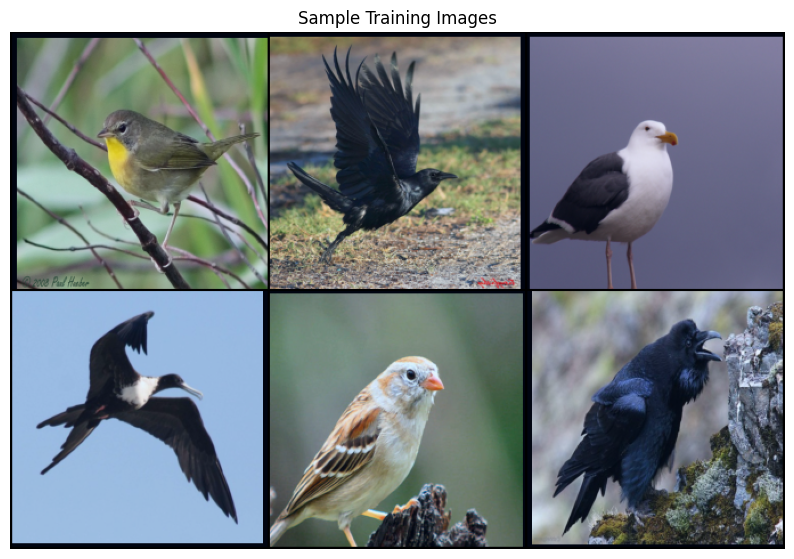

In [ ]:
from torchvision.utils import make_grid

images, labels = next(iter(train_loader))

# Create a grid of images
grid_img = make_grid(images[:6], nrow=3, padding=2, normalize=True)

# Visualize the grid of images
plt.figure(figsize=(10, 8))
plt.title('Sample Training Images')
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [ ]:
# Load pre-trained MobileNet V2 model
model = models.mobilenet_v2(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# Freeze pre-trained layers
for parameter in model.parameters():
    parameter.requires_grad = False

# Modify the final classifier layer
num_features = model.classifier[1].in_features  # Definining number of input features for the new layer
model.classifier[1] = nn.Linear(num_features, 200)  # Defining the final linear layer with input features and outputs

# Define loss function and optimizer
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


In [ ]:
# Defining a function for calculating testing accuracy
def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient calculation during evaluation
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    test_accuracy = correct_predictions / total_predictions
    return test_accuracy

In [ ]:
# Initialize arrays to store training losses and accuracies
training_losses = []
training_accuracies = []
testing_accuracies = []
epochs = 10

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    total_samples = 0
    correct_predictions = 0

    # Iterate over the training dataset
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    # Calculate epoch training loss and accuracy
    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples

    # Evaluate the model on the test dataset
    test_accuracy = evaluate_model(model, test_loader)

    # Append values to arrays
    training_losses.append(epoch_loss)
    training_accuracies.append(epoch_accuracy)
    testing_accuracies.append(test_accuracy)

    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}, Testing Accuracy: {test_accuracy:.4f}")


Epoch [9/10], Training Loss: 0.6958, Training Accuracy: 0.8324, Testing Accuracy: 0.5437
Epoch [10/10], Training Loss: 0.6129, Training Accuracy: 0.8524, Testing Accuracy: 0.5445


In [ ]:
# Save the current state of the model, optimizer, and other training-related parameters
checkpoint = {
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': epoch_loss
    }

# Define the file path where you want to save the checkpoint
checkpoint_path = 'checkpoint.pth'

# Save the checkpoint
torch.save(checkpoint, checkpoint_path)

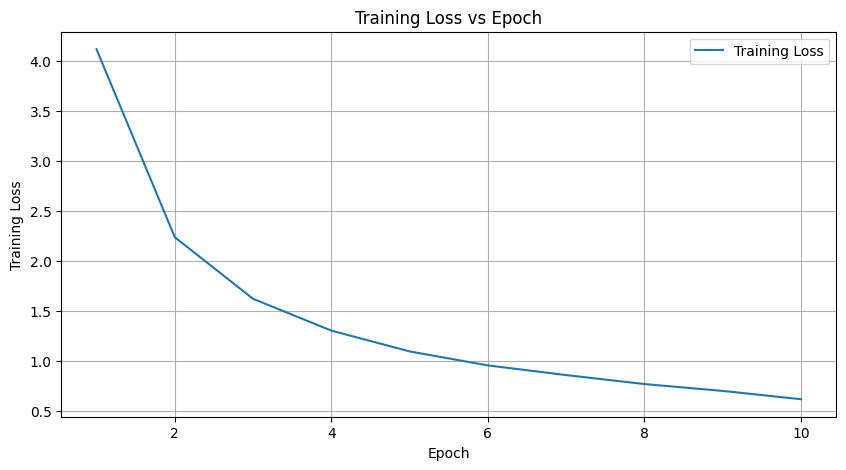

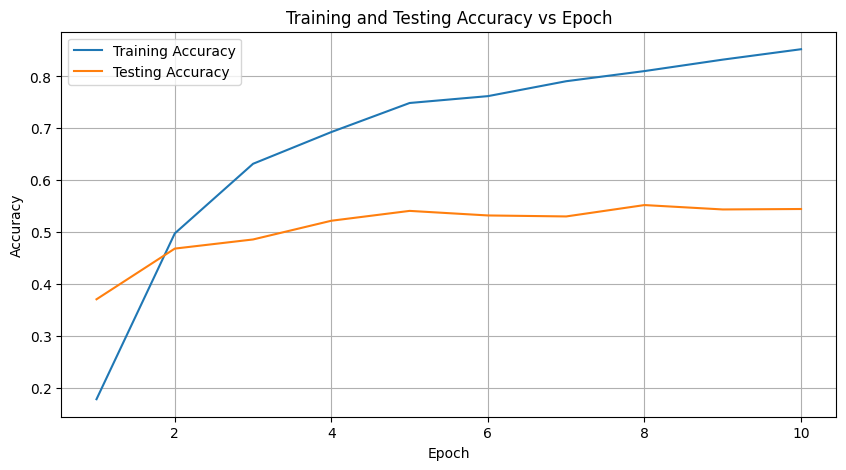

In [ ]:
# Plot training loss vs epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plot training accuracy and testing accuracy vs epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), training_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), testing_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()
